In [2]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [3]:
import numpy as np

# Chromosome-wide fold-changes

In [4]:
df = pd.read_csv("counts_df.csv", index_col=0)

In [6]:
adata = sc.AnnData(df.T)

In [9]:
adata.obs.index = ["-".join(i.split(".")) for i in adata.obs.index]

In [10]:
print(adata.shape)
sc.pp.filter_genes(adata, min_cells = 10)
print(adata.shape)

(20800, 21630)
(20800, 18099)


In [11]:
sc.pp.normalize_total(adata)

In [12]:
rearr = pd.read_csv("20240914_Lane2__1UMI_rearrangements.tsv", sep="\t", index_col=0)

In [16]:
rearr['key'] = rearr['rearranged_real_barcode1']+","+rearr['rearranged_real_barcode2']

In [18]:
del_cells = ['AAACCCAAGAGGATCC-1', 'AAACCCACAAATGCGG-1', 'AAAGAACTCAACTCTT-1',
       'AAAGTCCTCCAGCTCT-1', 'AAAGTGAAGCCTCTTC-1', 'AAATGGAAGCCGTCGT-1',
       'AAATGGAAGTAGTGCG-1', 'AAATGGAGTGCGTGCT-1', 'AACAAAGAGGCCTAGA-1',
       'AACAAAGCAAATGCGG-1', 'AACAACCGTGAGACGT-1', 'AACCTGAAGAATAGTC-1',
       'AACCTGATCCATACAG-1', 'AACGTCATCGGAATGG-1', 'AAGACAATCCACCTGT-1',
       'AAGACTCCACAAGTGG-1', 'AAGCCATAGGTTAAAC-1', 'AAGCGAGGTGTCCTAA-1',
       'AAGGTAACAACACACT-1', 'AAGGTAACAGACTCTA-1', 'AAGTACCCAAATTGGA-1',
       'AAGTCGTGTGATTGGG-1', 'AAGTCGTTCCCGGTAG-1', 'AAGTTCGGTCCCAAAT-1',
       'AATAGAGCATAGAATG-1', 'AATCGTGCACCGGCTA-1', 'AATGACCCAGCGCTTG-1',
       'AATGACCGTTACGTAC-1', 'AATGGAAGTTGGAGAC-1', 'AATGGCTGTGGAGAAA-1',
       'AATTTCCAGTCAGGGT-1', 'ACAACCACATGTACGT-1', 'ACAACCAGTCTTCATT-1',
       'ACAGCCGTCTCATTGT-1', 'ACATGCACAATCACGT-1', 'ACCGTTCAGTGCGACA-1',
       'ACCTACCAGGTACATA-1', 'ACCTGTCTCCGCAGTG-1', 'ACGATCAGTCATAAAG-1',
       'ACGGAAGGTCCGAAGA-1', 'ACGGGTCAGCTCACTA-1', 'ACGTAACCAGTCTACA-1',
       'ACGTAGTTCCTCTCTT-1', 'ACTGATGCACATTCTT-1', 'ACTGATGTCCAGCACG-1',
       'ACTGCAAAGCAGGGAG-1', 'ACTGCAATCGCCGAAC-1', 'ACTTAGGAGAAACACT-1',
       'ACTTCCGGTATCCTTT-1', 'ACTTTGTGTCGACTGC-1', 'AGAAATGAGATGACAT-1',
       'AGAAGCGCACGTACTA-1', 'AGACACTCATGACGGA-1', 'AGACACTTCACGGGAA-1',
       'AGACCATAGCTCAGAG-1', 'AGACTCAAGAGTACCG-1', 'AGACTCACAATTGAGA-1',
       'AGAGCCCCACGTACAT-1', 'AGAGCCCCATCACCAA-1', 'AGAGCCCCATTCGATG-1',
       'AGAGCCCGTGGAATGC-1', 'AGATCCAAGATTAGTG-1', 'AGATGAATCTTCACAT-1',
       'AGATGCTCAACTAGAA-1', 'AGATGCTTCAGACCTA-1', 'AGCGCCATCGCCCAGA-1',
       'AGCTACACATCCGCGA-1', 'AGCTCAAGTCGCCACA-1', 'AGGACTTCAACCGACC-1',
       'AGGATCTGTATCAAGA-1', 'AGGCTGCCAAACCATC-1', 'AGGCTGCGTCGCGTCA-1',
       'AGGTCATGTTAAGGAT-1', 'AGGTGTTAGCCTGACC-1', 'AGTAACCAGCAACAAT-1',
       'AGTACTGGTAGCTGTT-1', 'AGTACTGGTATTTCGG-1', 'AGTAGCTAGGAATTAC-1',
       'AGTAGCTTCTTGGCTC-1', 'AGTAGTCCACAAATAG-1', 'AGTCATGTCCGTGTAA-1',
       'AGTTAGCGTGACGCCT-1', 'AGTTAGCTCGACGATT-1', 'AGTTCCCAGTAAGACT-1',
       'ATACCTTAGGGCAATC-1', 'ATAGGCTAGATTACCC-1', 'ATAGGCTGTGTCATGT-1',
       'ATCACAGTCTCATTGT-1', 'ATCACTTGTACGAGCA-1', 'ATCAGGTAGCGCGTTC-1',
       'ATCCATTAGTCTGGTT-1', 'ATCCATTCACATTACG-1', 'ATCCTATTCTCTTCAA-1',
       'ATCGTGAGTGCCCTTT-1', 'ATCTCTATCTCGTCAC-1', 'ATGAAAGAGACTCGAG-1',
       'ATGCATGAGAGACAAG-1', 'ATGCATGAGTTGTCAC-1', 'ATGGATCCAGTTGTTG-1',
       'ATGGATCGTACTCGAT-1', 'ATGGATCGTCGTCAGC-1', 'ATGGATCGTGAGCTCC-1',
       'ATGTCCCAGTTGCATC-1', 'ATGTCTTAGGATCATA-1', 'ATTCAGGAGCATCTTG-1',
       'ATTCAGGCACAATCTG-1', 'ATTCAGGTCTGACAGT-1', 'ATTCCATCATCTGTTT-1',
       'ATTTACCGTGGTATGG-1', 'CAAAGAACATAACTCG-1', 'CAACAGTAGGGCAGGA-1',
       'CAACAGTAGTATAGAC-1', 'CAACCAAGTCGCAACC-1', 'CAACCTCAGTGGATTA-1',
       'CAACGGCTCCGCATAA-1', 'CAATTTCTCAGCAATC-1', 'CAATTTCTCGTACACA-1',
       'CACAGATGTGTCGCTG-1', 'CACCGTTGTTACTCAG-1', 'CACGAATGTCTCGGAC-1',
       'CACGGGTCACCCATAA-1', 'CACGGGTTCTCTATAC-1', 'CACGGGTTCTTGCAGA-1',
       'CACGTGGAGACCGTTT-1', 'CACTAAGCACAGACGA-1', 'CACTGTCTCAGCTTGA-1',
       'CAGAGCCAGTATGAAC-1', 'CAGAGCCGTGAATTGA-1', 'CAGATACTCTCGTCAC-1',
       'CAGATTGGTCTCTCCA-1', 'CAGCAATGTTGTGTTG-1', 'CAGCAGCAGGCATTTC-1',
       'CAGCCAGGTCACCGAC-1', 'CAGCCAGGTCACTCAA-1', 'CAGCCAGTCACCATGA-1',
       'CAGCGTGCAGCAGTGA-1', 'CAGCGTGTCACTGAAC-1', 'CAGGCCAAGTCACTAC-1',
       'CAGTTCCAGAGATCGC-1', 'CAGTTCCGTAGGTACG-1', 'CATACAGAGGCTATCT-1',
       'CATACCCGTGTATTCG-1', 'CATACTTTCACTGATG-1', 'CATCCACGTTCATCTT-1',
       'CATCCGTGTAACAAGT-1', 'CATCGTCCACACACTA-1', 'CATGAGTTCACCTCTG-1',
       'CATGCAATCTGTCTCG-1', 'CATGCCTTCAAATGCC-1', 'CATTCCGAGTATTGCC-1',
       'CATTGAGGTTGCTAGT-1', 'CATTGAGTCTGAGCAT-1', 'CATTGCCCAGCAGTCC-1',
       'CATTGTTGTGTCCAAT-1', 'CATTTCAAGCAGATAT-1', 'CCAAGCGCATTGAAAG-1',
       'CCACACTAGCCACCGT-1', 'CCACACTCACCTGAAT-1', 'CCACCATCACCCAACG-1',
       'CCACGTTGTAGACAGC-1', 'CCACGTTGTGCGTCGT-1', 'CCCTCAAGTGTACAGG-1',
       'CCCTCTCAGTCATGAA-1', 'CCGAACGCAGCTAACT-1', 'CCGGTAGAGACTTGTC-1',
       'CCGGTAGCATTCTCTA-1', 'CCGGTGAAGTTTCGAC-1', 'CCGTGAGAGATGAATC-1',
       'CCGTTCACACCAGGTC-1', 'CCGTTCAGTATGGAAT-1', 'CCTATCGGTGTGTACT-1',
       'CCTCAACTCGACGCTG-1', 'CCTCATGTCTGTCAGA-1', 'CCTCCTCAGGTTCATC-1',
       'CCTCCTCCACATGGTT-1', 'CCTCTAGTCGTGGGTC-1', 'CCTCTCCAGTGCAGCA-1',
       'CCTGCATGTATGGGAC-1', 'CCTGTTGAGGCAGTCA-1', 'CGAGAAGGTGGTATGG-1',
       'CGATGCGCAGTGCGCT-1', 'CGATGGCCAAGCAGGT-1', 'CGCAGGTTCGACATTG-1',
       'CGCATAAGTTTGATCG-1', 'CGCATGGGTAAGTTGA-1', 'CGCCATTTCGGTCGAC-1',
       'CGGACACGTGGCTAGA-1', 'CGTAAGTAGTAGCTCT-1', 'CGTCAAACAAAGTGTA-1',
       'CGTCAAATCAGTCTTT-1', 'CGTGATAAGCCGGATA-1', 'CGTTGGGAGGCTCTAT-1',
       'CTAAGTGAGAAGAGCA-1', 'CTAAGTGAGAGCTGAC-1', 'CTACAGAAGCCTATCA-1',
       'CTACGGGGTTACGATC-1', 'CTACTATTCCAATGCA-1', 'CTAGACACAGTCTTCC-1',
       'CTATCCGAGGATTTCC-1', 'CTATCTAGTAGAGGAA-1', 'CTATCTAGTATACCCA-1',
       'CTCAATTCAGCGATTT-1', 'CTCACTGAGACTTCAC-1', 'CTCAGGGGTGCATCTA-1',
       'CTCAGTCCATTCTCTA-1', 'CTCAGTCTCGAATCCA-1', 'CTCATTAAGTAGAGTT-1',
       'CTCCACAAGTTTCGAC-1', 'CTCCACAGTCCGGTCA-1', 'CTCCCAAGTAATGTGA-1',
       'CTCCCTCTCCATATGG-1', 'CTCCGATTCACCTCAC-1', 'CTGATCCTCCACGGAC-1',
       'CTGCAGGCAAAGGTTA-1', 'CTGCCATCAGTAGAGC-1', 'CTGCCTAGTGTTATCG-1',
       'CTGCCTATCTGCAGCG-1', 'CTGCTCAAGTCACACT-1', 'CTGGACGCAGAAATTG-1',
       'CTGTACCAGGAAGAAC-1', 'CTGTACCAGTTTCTTC-1', 'CTGTATTCAGAACTCT-1',
       'CTGTGGGGTGCACGCT-1', 'CTTCCGATCTACTTCA-1', 'CTTCTCTTCGTTAGAC-1',
       'CTTGATTGTGATTCTG-1', 'GAAACCTAGACCTCAT-1', 'GAAATGACATCACGGC-1',
       'GAACTGTGTCTCCCTA-1', 'GAAGTAAGTGTCATGT-1', 'GAATAGACAGATAAAC-1',
       'GAATCACAGCTTACGT-1', 'GAATCACGTGCACATT-1', 'GAATCGTCACCTAAAC-1',
       'GACCCTTGTGAAGCTG-1', 'GACGCTGCAGACTCTA-1', 'GACTATGGTGTCTTCC-1',
       'GACTCTCCAATTAGGA-1', 'GAGCCTGAGTTTGTCG-1', 'GAGTCTAGTGCTTCAA-1',
       'GAGTGAGAGTGCACAG-1', 'GATAGCTTCAGTCATG-1', 'GATCATGTCCTACGGG-1',
       'GATCCCTTCCGACGGT-1', 'GATCCCTTCGACCCAG-1', 'GATGTTGCAGGAGGAG-1',
       'GATGTTGCATCTATCT-1', 'GCACATACATAATCCG-1', 'GCAGGCTGTCTTCAAG-1',
       'GCAGGCTTCGTTTACT-1', 'GCATCGGCAACAACAA-1', 'GCATCTCTCGGTCACG-1',
       'GCATTAGCAAGTATAG-1', 'GCCAACGAGGTTTACC-1', 'GCCAACGCAAGTTCGT-1',
       'GCCAGCACATTCGATG-1', 'GCCAGTGTCTGGAGAG-1', 'GCCATGGAGGAGGGTG-1',
       'GCCCGAAAGTTGCGCC-1', 'GCCGATGAGTGATGGC-1', 'GCCGATGTCCACTAGA-1',
       'GCCGTGACAAAGAGTT-1', 'GCCTGTTTCATAGCAC-1', 'GCTGAATCAGCAGTAG-1',
       'GCTGCAGCAGTCAGTT-1', 'GGAAGTGGTCTTACTT-1', 'GGAGATGGTATGTCCA-1',
       'GGAGCAAAGACCATTC-1', 'GGAGGTACACGTAGAG-1', 'GGATGTTCAACACAGG-1',
       'GGCAGTCCATGACTGT-1', 'GGCTTGGCAGCCTACG-1', 'GGCTTTCCACAGTCAT-1',
       'GGGACAAAGGACGCAT-1', 'GGGACAAGTCGTTATG-1', 'GGGACAAGTGCAAGAC-1',
       'GGGACTCGTACAACGG-1', 'GGGACTCGTCCTGGTG-1', 'GGGATGAGTTGGCCGT-1',
       'GGGCTCATCCCTCGTA-1', 'GGGTCTGGTGTCTTCC-1', 'GGGTGAAGTTACGATC-1',
       'GGTAACTCATCCGATA-1', 'GGTAATCCAAATTGCC-1', 'GGTCACGAGCGCCTCA-1',
       'GGTGAAGAGTGGTGAC-1', 'GGTGAAGCAACTGCCG-1', 'GGTGATTGTTGCGTAT-1',
       'GGTTCTCCACAAGCCC-1', 'GTAAGTCGTCAGGTAG-1', 'GTAGAAATCGTCAGAT-1',
       'GTAGAGGCATAGAAAC-1', 'GTAGGAGCAAGACAAT-1', 'GTAGGAGGTAGTGGCA-1',
       'GTAGGAGTCTTGTGCC-1', 'GTCACTCGTTAGGACG-1', 'GTCAGCGAGAGTACCG-1',
       'GTCATTTTCAATCAGC-1', 'GTCCACTCACTTGAAC-1', 'GTCCACTTCGGCATCG-1',
       'GTCGTAAAGGTGCCTC-1', 'GTCGTAAGTTCGAACT-1', 'GTCTAGAGTTAGGACG-1',
       'GTCTCACTCCCAGCGA-1', 'GTCTGTCCAAGTACCT-1', 'GTGACGCTCTCTCTAA-1',
       'GTGAGCCGTCTGTGAT-1', 'GTGAGCCGTTCATCTT-1', 'GTGAGTTGTGCAGTGA-1',
       'GTGCACGTCAAGCTTG-1', 'GTGCTGGTCTCGCGTT-1', 'GTGCTTCCACAGGATG-1',
       'GTGGAAGCAGGTTCCG-1', 'GTGGTTAAGCAGGCAT-1', 'GTGTAACTCCAGTGCG-1',
       'GTGTCCTAGTGTTGAA-1', 'GTTACCCGTGGGCTCT-1', 'GTTAGTGTCTACGCGG-1',
       'GTTCATTCAGCACAGA-1', 'GTTCATTGTGTTACAC-1', 'GTTCATTTCGCTTGCT-1',
       'GTTCGCTTCACACCCT-1', 'GTTGAACCAGAAGTGC-1', 'GTTGCGGAGAGTCGAC-1',
       'GTTGTGAAGGGAGATA-1', 'TAACCAGCACTAGGTT-1', 'TAATCTCAGGTAAGAG-1',
       'TACAGGTCAAAGACGC-1', 'TACATTCGTGTAAATG-1', 'TACCCACCATGTGACT-1',
       'TACCGGGAGACATAAC-1', 'TACGGGCAGGTTCAGG-1', 'TACGGTAGTAGTGTGG-1',
       'TACTTACAGCCAGACA-1', 'TAGAGTCTCGAGCACC-1', 'TAGCACACAATATCCG-1',
       'TAGCACAGTAGACTGG-1', 'TAGCACAGTGCATTTG-1', 'TAGGGTTTCTAAGGAA-1',
       'TAGGTACCAGTGTGGA-1', 'TATACCTCAATTTCCT-1', 'TATCAGGCAATACCTG-1',
       'TATCGCCAGTGGGAAA-1', 'TATCTGTTCCCAGTGG-1', 'TATGTTCGTCCCTGAG-1',
       'TATGTTCTCTAGCAAC-1', 'TATTGGGCAGTCAACT-1', 'TATTTCGTCGGTCGGT-1',
       'TCAAGTGAGTTGCTGT-1', 'TCAAGTGCATCAGTCA-1', 'TCAAGTGTCTTACCAT-1',
       'TCAATCTAGAGGTCAC-1', 'TCAATCTGTGAGTTGG-1', 'TCACATTAGTTAGAAC-1',
       'TCACGGGAGAGGGTGG-1', 'TCAGCCTAGCACTCAT-1', 'TCAGTTTCACCCAATA-1',
       'TCATACTGTTCGTTCC-1', 'TCATATCGTGTGATGG-1', 'TCATGCCGTTCCACAA-1',
       'TCATGGATCGCCATAA-1', 'TCATTACGTCAGGTGA-1', 'TCATTACGTGTTGAGG-1',
       'TCATTGTAGAATCTAG-1', 'TCATTGTCACGGAAGT-1', 'TCATTTGGTTGACGGA-1',
       'TCCATGCAGCTAGCCC-1', 'TCCATGCCACTCCTTG-1', 'TCCCATGGTAGACACG-1',
       'TCCCATGTCCACTTTA-1', 'TCCGAAATCAGTCACA-1', 'TCCTAATCACCTTCGT-1',
       'TCCTAATGTGGCTTAT-1', 'TCCTCCCGTGGTCTAT-1', 'TCCTCGATCCGCACTT-1',
       'TCCTCTTTCACGGGAA-1', 'TCCTGCAGTATGGTAA-1', 'TCCTGCATCGCGAAGA-1',
       'TCCTTCTAGGGCAGAG-1', 'TCCTTCTCAGTTGAAA-1', 'TCCTTTCCAATCGCGC-1',
       'TCGACGGTCTCGTTTA-1', 'TCGATTTTCGTCCATC-1', 'TCGCTTGGTTCCACAA-1',
       'TCGGGCAGTTAGTTCG-1', 'TCGGTCTAGTGTCATC-1', 'TCGGTCTTCTGAGTCA-1',
       'TCTAACTTCGACATAC-1', 'TCTACATGTACAGTTC-1', 'TCTCTGGCAAATGGCG-1',
       'TCTGTCGTCCAACTGA-1', 'TCTTAGTGTTTCACAG-1', 'TCTTTGACATCCGAAT-1',
       'TGAATCGCACTTGGGC-1', 'TGACCCTCAGCAAGAC-1', 'TGACGCGAGTGCAAAT-1',
       'TGAGGAGTCCGGACGT-1', 'TGAGGTTCACGTAGAG-1', 'TGATCAGCAATACCTG-1',
       'TGATCTTTCAACCCGG-1', 'TGCACGGGTGCCCGTA-1', 'TGCAGGCAGGTGCATG-1',
       'TGCAGGCCAGGGTCTC-1', 'TGCATCCGTATCAGGG-1', 'TGCATCCGTATCGATC-1',
       'TGCATGACAGATCACT-1', 'TGCCGAGGTCATCCCT-1', 'TGCTCGTCAGCAAGAC-1',
       'TGGAACTTCCGGTAAT-1', 'TGGAGAGGTGCACGCT-1', 'TGGAGGAAGACATACA-1',
       'TGGGAAGCAAATCGTC-1', 'TGGGAAGTCCCATACC-1', 'TGGGAAGTCGCTTAAG-1',
       'TGGGTTAAGCGTCAAG-1', 'TGGTACAAGCACTCGC-1', 'TGGTAGTCACAATGAA-1',
       'TGGTAGTGTAATCAGA-1', 'TGGTTAGAGGCACAAC-1', 'TGGTTAGAGTGGATTA-1',
       'TGTCAGACAGATCACT-1', 'TGTCCCACAACCGACC-1', 'TGTCCTGCATGACGAG-1',
       'TGTGCGGAGATCCAAA-1', 'TGTTACTCAGTAGGAC-1', 'TGTTCTAAGTAAGACT-1',
       'TGTTCTAGTCAAATCC-1', 'TGTTCTAGTCTCAAGT-1', 'TGTTGAGCAAGACCTT-1',
       'TTAATCCAGCCGTAAG-1', 'TTACCATCATCCTATT-1', 'TTACGCCTCATCTACT-1',
       'TTCAATCCAATACCCA-1', 'TTCAATCGTTAGGAGC-1', 'TTCATTGCATCCGCGA-1',
       'TTCATTGGTTAGAGTA-1', 'TTCCACGCACTCTCGT-1', 'TTCCGTGCAGCTGCCA-1',
       'TTCCGTGTCCAAGAGG-1', 'TTCCTAATCACTTCTA-1', 'TTCCTCTGTCTTCCGT-1',
       'TTCCTTCCAGCAGGAT-1', 'TTCGATTAGTACAGAT-1', 'TTGAACGGTCTAGGTT-1',
       'TTGAACGGTCTGCCTT-1', 'TTGACCCAGAAACTAC-1', 'TTGAGTGTCCATACAG-1',
       'TTGATGGCACCCTAGG-1', 'TTGATGGGTATGCTTG-1', 'TTGCGTCCATCTCAAG-1',
       'TTGCGTCTCTCCTACG-1', 'TTGCGTCTCTTCGGAA-1', 'TTGGGATCACATATCG-1',
       'TTGGGTATCCCAAGCG-1', 'TTGTGGAGTACCTAGT-1', 'TTGTGTTGTGACTAAA-1',
       'TTTACGTTCTGGGCCA-1', 'TTTCACACAGTCTCTC-1', 'TTTCATGAGCAGCAGT-1',
       'TTTCGATCAGCACGAA-1', 'TTTGATCAGCCGAACA-1', 'TTTGATCAGGTCTACT-1',
       'TTTGATCGTATGAGCG-1', 'TTTGTTGCACTTGTCC-1', 'TTTGTTGGTGTACAGG-1']

In [19]:
parent_cells = ['AAACGCTTCTGACAGT-1', 'AAAGGGCCAACAAGTA-1', 'AAAGGTAAGGCTATCT-1',
       'AAAGGTAAGGTCGCCT-1', 'AACAAAGTCTAGTACG-1', 'AACAACCTCAGGACGA-1',
       'AACAACCTCCATGATG-1', 'AACAGGGCAAGTGTCT-1', 'AACAGGGTCATTCGGA-1',
       'AACCAACAGGTAGCCA-1', 'AACCAACCAAATGATG-1', 'AACCATGCAGCCGTTG-1',
       'AACCCAAAGCTAATCC-1', 'AACCCAATCTTGGTGA-1', 'AACCTTTGTCTGCGCA-1',
       'AACGGGAAGTCAACAA-1', 'AACGTCACAACTCCCT-1', 'AACGTCATCTCCGCAT-1',
       'AAGACTCAGGTCATAA-1', 'AAGCCATCACGACCTG-1', 'AAGCGTTGTAGGACTG-1',
       'AAGTACCAGTAATACG-1', 'AATAGAGTCGTGTGGC-1', 'AATCGTGAGGAGAGGC-1',
       'AATCGTGAGGTGATCG-1', 'AATCGTGGTAGCGATG-1', 'AATGACCAGTGTGTTC-1',
       'AATGCCAGTATCGTAC-1', 'AATGGAAAGCTGTTAC-1', 'AATTCCTCAATGTCTG-1',
       'AATTCCTGTTCCGGTG-1', 'ACAAGCTCATCAGTGT-1', 'ACACGCGCACGCAAAG-1',
       'ACACGCGGTACAAACA-1', 'ACACTGAGTAGAGGAA-1', 'ACAGAAACATTGACCA-1',
       'ACAGGGAGTACTGTTG-1', 'ACATCGATCCACACCT-1', 'ACATGCAAGCCAAGCA-1',
       'ACATTTCAGGACTAAT-1', 'ACATTTCCAGATCACT-1', 'ACCAAACAGGATTCCT-1',
       'ACCAAACCATTGTCGA-1', 'ACCAAACGTGAGACGT-1', 'ACCAACATCCACAAGT-1',
       'ACCATTTGTCTCTCTG-1', 'ACCCAAACAACGAGGT-1', 'ACCTACCGTCTCACAA-1',
       'ACCTACCGTGAGATTA-1', 'ACGATGTGTATGGTAA-1', 'ACGCACGCAACTACGT-1',
       'ACGGGTCAGAAGGTAG-1', 'ACGGGTCTCTGAGTCA-1', 'ACGGTCGAGAATTCAG-1',
       'ACGGTCGCAACGTAAA-1', 'ACGGTTAAGCGCATCC-1', 'ACGTACACACTACACA-1',
       'ACGTACACAGAGGTTG-1', 'ACGTAGTCAAGGTCGA-1', 'ACGTCCTAGTAAACTG-1',
       'ACGTCCTAGTCTAGCT-1', 'ACGTCCTGTGCAACAG-1', 'ACGTTCCCAACAAGTA-1',
       'ACTACGATCCTGGGTG-1', 'ACTATGGCAGCTATTG-1', 'ACTGTCCGTTTCAGAC-1',
       'ACTTAGGTCACATTGG-1', 'ACTTATCCACCGTGGT-1', 'ACTTATCGTAACGGTG-1',
       'ACTTATCGTTTGCAGT-1', 'ACTTCCGCACTGGCGT-1', 'ACTTCCGCATTCTCTA-1',
       'ACTTCCGTCGGTCATA-1', 'ACTTTGTCAGATACTC-1', 'AGAAATGAGTATGAAC-1',
       'AGAACAAGTCACGCTG-1', 'AGAACAAGTGCTCTTC-1', 'AGAACCTAGGGCAGAG-1',
       'AGAACCTAGTCGGGAT-1', 'AGAAGTAAGTATGCAA-1', 'AGAAGTATCATAGAGA-1',
       'AGACACTGTACAAGTA-1', 'AGACTCACAGGTGAGT-1', 'AGAGCAGAGCACTCGC-1',
       'AGATAGAAGTCATAGA-1', 'AGATAGAAGTCTTCCC-1', 'AGATAGAGTATAGGAT-1',
       'AGATAGAGTATGAAGT-1', 'AGATCGTTCAAGTGGG-1', 'AGATCGTTCCTCTCGA-1',
       'AGATGCTAGCGAGTCA-1', 'AGATGCTCACTCCGAG-1', 'AGCATCACAAGGTCTT-1',
       'AGCCAGCGTCCGAAAG-1', 'AGCGCCACAGTCTACA-1', 'AGCGCCAGTTAGGGTG-1',
       'AGCGCCATCACCCTCA-1', 'AGCGCTGAGAATCGTA-1', 'AGCGTATGTCATCCCT-1',
       'AGCGTCGAGCGAATGC-1', 'AGCGTCGGTACGCTAT-1', 'AGCTTCCGTTACCGTA-1',
       'AGGACGACATCCGATA-1', 'AGGACGAGTGTTAGCT-1', 'AGGACTTAGAGGGTGG-1',
       'AGGACTTCAACGACAG-1', 'AGGAGGTGTTCTAACG-1', 'AGGCATTAGATGAACT-1',
       'AGGCATTCATAACAGA-1', 'AGGCATTGTACTAGCT-1', 'AGGCCACTCACGGAGA-1',
       'AGGCTGCCAGCACACC-1', 'AGGGAGTCACTGCACG-1', 'AGGTCATGTGGAATGC-1',
       'AGGTCATGTTTCGTGA-1', 'AGGTCTATCATCTACT-1', 'AGGTCTATCCCGAAAT-1',
       'AGGTGTTGTTTCACTT-1', 'AGTAACCCACTGGCCA-1', 'AGTAACCCAGTCGAGA-1',
       'AGTACCAGTGAGTAGC-1', 'AGTCAACCATGCAGCC-1', 'AGTCAACTCGATACAC-1',
       'AGTCACAGTGTGACCC-1', 'AGTGACTGTGCAAGAC-1', 'AGTGTTGCACAAATCC-1',
       'AGTTAGCTCCATAAGC-1', 'ATACCTTAGGTAGACC-1', 'ATAGACCAGGCTGTAG-1',
       'ATAGAGAAGCAGTCTT-1', 'ATAGAGATCCACTGGG-1', 'ATCACAGGTGGTCTGC-1',
       'ATCATTCGTAACATCC-1', 'ATCCCTGCAGTCGAGA-1', 'ATCGATGGTGCGACAA-1',
       'ATCGGCGTCATGGTAC-1', 'ATCGTAGGTCCACAGC-1', 'ATCGTGAAGCTATCTG-1',
       'ATCGTGAGTAGGAAAG-1', 'ATGAAAGAGAGTCTTC-1', 'ATGAAAGGTTTACGTG-1',
       'ATGAGGGAGCTTACGT-1', 'ATGCATGGTTCTCTAT-1', 'ATGCATGTCAGCACCG-1',
       'ATGCCTCTCTACGGTA-1', 'ATGCGATAGACGCATG-1', 'ATGCGATCACTGTCGG-1',
       'ATGGAGGAGCATTGTC-1', 'ATGGATCGTCCACGCA-1', 'ATGGGAGAGCTTTCCC-1',
       'ATGGGTTGTCAGGTAG-1', 'ATGGTTGCATCTAGAC-1', 'ATTCACTGTGCCTGAC-1',
       'ATTCCTATCCCAGGAC-1', 'ATTCTACAGACTCCGC-1', 'ATTGGGTCAACACGAG-1',
       'ATTTACCGTAGTCTTG-1', 'ATTTCTGCATGAAAGT-1', 'CAAAGAACATCGGCCA-1',
       'CAACAACAGCTGTCCG-1', 'CAACAGTAGGGATCAC-1', 'CAACCAATCGTCCTTG-1',
       'CAACCTCCAACATCGT-1', 'CAACCTCGTGTGTCCG-1', 'CAACGATGTTCAAAGA-1',
       'CAACGGCTCTCGTCGT-1', 'CAATACGAGTCTGGAG-1', 'CAATACGGTCTACAAC-1',
       'CAATACGTCGAGAAGC-1', 'CAATTTCAGCCTGGAA-1', 'CACAACAAGCGTTCAT-1',
       'CACAACAGTTCTCCCA-1', 'CACATGATCCCATTTA-1', 'CACCAAAAGACGAGCT-1',
       'CACCAAAAGGATGTTA-1', 'CACGGGTCACCAGCGT-1', 'CACGTGGAGCGTTCCG-1',
       'CACGTGGGTGAGTGAC-1', 'CACGTTCAGCGTTCCG-1', 'CACTGAACATGGCTAT-1',
       'CACTTCGAGATAGTGT-1', 'CACTTCGAGCAAGTCG-1', 'CACTTCGGTCACGTGC-1',
       'CACTTCGTCTTTGCGC-1', 'CAGATACAGCCACTCG-1', 'CAGATACGTCGCATGC-1',
       'CAGATACTCTATCGCC-1', 'CAGATCATCTCTCAAT-1', 'CAGCGTGGTATTCCGA-1',
       'CAGCGTGGTTCTCTCG-1', 'CAGGCCACACGGTGTC-1', 'CAGGGCTTCTCCCAAC-1',
       'CAGGTATGTATTGGCT-1', 'CAGTGCGCAACGTATC-1', 'CATAAGCAGGTTGCCC-1',
       'CATACAGCAGTGGCTC-1', 'CATACAGTCGACCTAA-1', 'CATAGACTCCGTGTCT-1',
       'CATCCACAGATACCAA-1', 'CATCCCATCAGGAACG-1', 'CATCCGTGTTCCGCTT-1',
       'CATCGTCGTGATTAGA-1', 'CATGAGTAGCGCTGCT-1', 'CATGAGTCACAAGCCC-1',
       'CATGAGTTCCAAACCA-1', 'CATGCCTAGGTATCTC-1', 'CATGCCTTCCGGCAGT-1',
       'CATGCGGGTTCTCTCG-1', 'CATGCTCAGTGGACGT-1', 'CATGGATAGTTGGAGC-1',
       'CATGGATGTGGTTCTA-1', 'CATGGATTCTAGTTCT-1', 'CATGGTACATCGTGGC-1',
       'CATTCATAGGGCAACT-1', 'CATTCATGTGCGAACA-1', 'CATTCCGAGGTTAGTA-1',
       'CATTCTAAGGATGCGT-1', 'CATTCTACACCGTCGA-1', 'CATTGAGAGCTCGTGC-1',
       'CATTGTTGTGTTAAAG-1', 'CCAAGCGTCACTAGCA-1', 'CCAATGACAGCAATTC-1',
       'CCAATGAGTGGTCTAT-1', 'CCAATGATCTGCTTAT-1', 'CCATAAGCATCCCGTT-1',
       'CCATCACAGACGCCAA-1', 'CCATCACGTATTTCGG-1', 'CCCATTGCAGAGGTAC-1',
       'CCCGAAGAGGGCGAAG-1', 'CCCGGAACAGGCGATA-1', 'CCCTAACGTGACTATC-1',
       'CCCTAACGTTGAGGAC-1', 'CCCTTAGGTAGGCTGA-1', 'CCCTTAGTCGCTGACG-1',
       'CCGAACGAGGTAGTAT-1', 'CCGAACGAGTGCGTCC-1', 'CCGAACGCAAAGGTTA-1',
       'CCGATCTCACGCTTAA-1', 'CCGATCTGTCAGACTT-1', 'CCGATCTTCGAAACAA-1',
       'CCGATGGCAACAGATA-1', 'CCGCAAGAGGATACCG-1', 'CCGCAAGAGTCTGGAG-1',
       'CCGGGTACACCGGAAA-1', 'CCGGGTACAGTCTTCC-1', 'CCGGGTAGTAACAGGC-1',
       'CCGGGTATCAGTAGGG-1', 'CCGGTGAAGATTGATG-1', 'CCGTAGGCAACCAACT-1',
       'CCGTGAGAGTCTTGGT-1', 'CCTACGTCACAGACGA-1', 'CCTCAACGTGGTCTCG-1',
       'CCTCAACTCGACGATT-1', 'CCTCACAGTTCCGCGA-1', 'CCTCACATCTTGGATG-1',
       'CCTCATGAGACTACCT-1', 'CCTCATGAGGTAAAGG-1', 'CCTCCAAAGGCCATAG-1',
       'CCTCCAAGTCTCGCGA-1', 'CCTCCTCAGTAGGAAG-1', 'CCTTCAGAGGATACCG-1',
       'CCTTCAGTCCGAAGGA-1', 'CGAAGGACACTAACGT-1', 'CGACAGCCAAATACAG-1',
       'CGAGTTAGTTATGGTC-1', 'CGATCGGTCTCGGGAC-1', 'CGATGCGCAAGTGACG-1',
       'CGATGCGGTGCCTGCA-1', 'CGATGCGTCCCGATCT-1', 'CGCAGGTAGCTGCCAC-1',
       'CGGAACCCACCACATA-1', 'CGGAATTAGACGCATG-1', 'CGGAATTGTCCTCCTA-1',
       'CGGGTGTTCTGAGTCA-1', 'CGTAATGAGTGAGTGC-1', 'CGTAATGCAGGAAGTC-1',
       'CGTAATGGTGAATTAG-1', 'CGTAGTATCTCTGAGA-1', 'CGTCCATGTGTGCCTG-1',
       'CGTGAATTCCTCTCGA-1', 'CGTGTCTAGACAACTA-1', 'CGTTAGACAGTCGGAA-1',
       'CGTTCTGTCGTTAGTG-1', 'CTAACTTAGGCGAAGG-1', 'CTAACTTCATCTCGTC-1',
       'CTAAGTGTCTCTGGTC-1', 'CTACCTGTCCACACAA-1', 'CTAGGTACAGGGACTA-1',
       'CTCAAGAGTGGATCGA-1', 'CTCAGGGCATATCTGG-1', 'CTCATCGGTAACATCC-1',
       'CTCCATGAGCCTGTGC-1', 'CTCCATGCAGCTACAT-1', 'CTCCTTTAGCCAAGCA-1',
       'CTCGAGGAGTTCGGTT-1', 'CTCTCGATCTCTCTTC-1', 'CTCTCGATCTTTACAC-1',
       'CTCTGGTAGTACCCTA-1', 'CTCTGGTTCTGACAGT-1', 'CTGAGGCGTGCATCTA-1',
       'CTGCATCCAAGAGTGC-1', 'CTGCCATAGATCGACG-1', 'CTGCCATGTTTACACG-1',
       'CTGCCTAAGTCACGAG-1', 'CTGCTCAAGTCACTCA-1', 'CTGGACGAGTATGAAC-1',
       'CTGGACGCATCGGAGA-1', 'CTGGTCTGTTAGTCGT-1', 'CTGTACCCAAAGGAGA-1',
       'CTGTATTTCTCCGTGT-1', 'CTGTCGTCACATGAAA-1', 'CTGTCGTGTCACCTTC-1',
       'CTGTGAACAGGCTATT-1', 'CTTCCTTGTTCCACAA-1', 'CTTGAGACAACCGCTG-1',
       'CTTTCAAAGCAATTCC-1', 'CTTTCGGGTCGAGATG-1', 'GAAACCTCATTGACAC-1',
       'GAACACTCAATCGTCA-1', 'GAACTGTCACTCCTTG-1', 'GAAGCCCCAACTCCCT-1',
       'GAAGCCCGTTGGCCGT-1', 'GAAGGACAGGGCAGAG-1', 'GAAGGACCACCAGCTG-1',
       'GAAGGGTTCACACCCT-1', 'GAAGTAAAGTAACCTC-1', 'GAATAGAGTATTGAGA-1',
       'GACCAATCACGATAGG-1', 'GACCAATGTCAGCTTA-1', 'GACCCTTAGGCGATAC-1',
       'GACCCTTCAAATCGGG-1', 'GACCCTTTCTCGCTTG-1', 'GACGTTAAGGTTAGTA-1',
       'GACTATGAGTAGTCAA-1', 'GACTCTCTCCACAGCG-1', 'GACTGATAGAAGCTCG-1',
       'GACTTCCAGCTTAAGA-1', 'GACTTCCGTCACTACA-1', 'GAGAAATAGACGGAAA-1',
       'GAGAAATGTATCGCAT-1', 'GAGACCCCATGGTGGA-1', 'GAGACCCTCACCATGA-1',
       'GAGAGGTCAAACCGGA-1', 'GAGATGGGTCCGTACG-1', 'GAGCCTGCAACAAGAT-1',
       'GAGCCTGGTCGTATTG-1', 'GAGCTGCGTCAGCGTC-1', 'GAGGGATAGCGATCGA-1',
       'GAGGGTACACACAGCC-1', 'GAGTCATCATACGCAT-1', 'GAGTGAGGTCATTCCC-1',
       'GAGTGAGGTGTGACCC-1', 'GAGTGAGGTTTACACG-1', 'GATCAGTAGGTGGCTA-1',
       'GATCAGTTCGTGCACG-1', 'GATCGTACACTACAGT-1', 'GATGACTTCCAACTGA-1',
       'GATGAGGTCCATACTT-1', 'GATGCTATCCAAACCA-1', 'GATGGAGGTCAGTCTA-1',
       'GATGGAGTCGTTTACT-1', 'GATTGGTCAATGAGCG-1', 'GCAACATGTGTTGACT-1',
       'GCAACCGGTCCTCAGG-1', 'GCACATACAGTCGCTG-1', 'GCACGGTAGACTTCGT-1',
       'GCACTAATCATCGCAA-1', 'GCAGCCATCTACCAGA-1', 'GCATTAGGTCAGCGTC-1',
       'GCATTAGGTGTCTTAG-1', 'GCCAACGCATGGTGGA-1', 'GCCAGCAGTTCGAACT-1',
       'GCCAGTGAGAACAAGG-1', 'GCGATCGAGGTGGGTT-1', 'GCGTGCATCGCTACGG-1',
       'GCGTTTCCAGTAACCT-1', 'GCTACAAGTGCAGTGA-1', 'GCTCAAAGTCCAGCCA-1',
       'GCTGAATAGCTAGATA-1', 'GCTGCAGGTACAGAGC-1', 'GCTGGGTAGTCACGCC-1',
       'GGAAGTGAGGCTCTCG-1', 'GGAATGGGTATGTGTC-1', 'GGAGATGAGCGCACAA-1',
       'GGAGCAACATCCTCAC-1', 'GGAGGTAAGGACATCG-1', 'GGAGGTACAGCGCGTT-1',
       'GGAGGTAGTGTGGTCC-1', 'GGAGGTATCTATGTGG-1', 'GGCGTCACATCCGAGC-1',
       'GGCTTTCGTGCCGAAA-1', 'GGGAAGTAGATGAACT-1', 'GGGACCTAGTTGGCTT-1',
       'GGGACCTTCCATCTGC-1', 'GGGACTCGTCCGCAGT-1', 'GGGAGATAGATGTTGA-1',
       'GGGAGTAGTAGGTCAG-1', 'GGGATGAGTCTGTGGC-1', 'GGGCGTTGTTGGGCCT-1',
       'GGGCTACGTTAAAGTG-1', 'GGGTAGAAGTGTCATC-1', 'GGGTCTGGTGTTCCAA-1',
       'GGGTCTGTCTGCATAG-1', 'GGGTTATTCACACCGG-1', 'GGGTTTACAGTGAGCA-1',
       'GGTCTGGAGGTAGACC-1', 'GGTGAAGGTCACCGCA-1', 'GGTTCTCTCGCGTGAC-1',
       'GGTTGTACAGCGTTGC-1', 'GTAACACCACATCCCT-1', 'GTAACACGTCGATTAC-1',
       'GTAACACTCCCGTTCA-1', 'GTAAGTCAGTCGGCCT-1', 'GTAATCGTCAGTGGGA-1',
       'GTAATGCAGCGACATG-1', 'GTACAACAGAACGCGT-1', 'GTACAACGTGGGACAT-1',
       'GTACAGTAGGTTGCCC-1', 'GTACAGTCAGTAACGG-1', 'GTAGCTATCAAGCGTT-1',
       'GTAGGAGCACAAGGTG-1', 'GTAGTACCAGGTCTCG-1', 'GTATTTCGTCGTATGT-1',
       'GTATTTCTCAAGATAG-1', 'GTCAAACCAATACGCT-1', 'GTCAAGTCAACAGATA-1',
       'GTCACGGTCAAGGAGC-1', 'GTCACTCTCTAGGAAA-1', 'GTCATCCGTTCTATCT-1',
       'GTCATGATCATAGACC-1', 'GTCCCATTCAGCCCAG-1', 'GTCGCGATCGACCAAT-1',
       'GTCGTTCAGTTACGGG-1', 'GTCTACCGTTATGTCG-1', 'GTCTCACCATCGTCCT-1',
       'GTCTCACGTAAGTTGA-1', 'GTCTCACTCGCCAGAC-1', 'GTGAGCCGTTCAGTAC-1',
       'GTGATGTCACGTACAT-1', 'GTGCACGAGGGAGTTC-1', 'GTGCACGTCGTCTCAC-1',
       'GTGCAGCGTGTGTCCG-1', 'GTGCGTGGTGAGCAGT-1', 'GTGCTTCTCCATCAGA-1',
       'GTGGAAGCATCTAACG-1', 'GTGGAGATCATTGCTT-1', 'GTGGCGTTCGGTCATA-1',
       'GTGTAACCACCGTCTT-1', 'GTGTTAGAGGATTTGA-1', 'GTGTTAGTCTGTCAGA-1',
       'GTGTTCCTCCCGAACG-1', 'GTTACAGCAGTCGGTC-1', 'GTTACCCGTGCTCTCT-1',
       'GTTAGACCAAATACAG-1', 'GTTAGACTCAGGCGAA-1', 'GTTAGTGAGTGTAGTA-1',
       'GTTAGTGCAGACCAAG-1', 'GTTAGTGTCTCGAGTA-1', 'GTTATGGAGCTTTGTG-1',
       'GTTATGGAGGACTAAT-1', 'GTTATGGCAAACACGG-1', 'GTTCATTCACTGAGGA-1',
       'GTTCCGTCAGGCATGA-1', 'GTTCGCTTCGGTGTAT-1', 'GTTCTATCACAATGAA-1',
       'GTTCTATCAGCGTATT-1', 'GTTCTATCAGGAATCG-1', 'GTTGAACAGCGACTAG-1',
       'GTTGAACTCCTAGCTC-1', 'GTTGCGGAGCGTCAGA-1', 'GTTGCGGCAACGACTT-1',
       'GTTGCGGTCTGGTTGA-1', 'GTTGCTCGTACCCACG-1', 'GTTGCTCTCAGCAATC-1',
       'GTTGTAGGTCGCGTCA-1', 'GTTGTCCAGACAGCTG-1', 'TAACGACAGGGTGAAA-1',
       'TAACGACTCCCTTGTG-1', 'TAATCTCAGCACTCGC-1', 'TACAACGAGAGTGTGC-1',
       'TACAACGTCTCCGCAT-1', 'TACCCGTGTGTCTCCT-1', 'TACCGGGAGAGGTCAC-1',
       'TACCTGCAGTTGTACC-1', 'TACGGGCAGTCAGGGT-1', 'TACTGCCCACTCATAG-1',
       'TACTTACGTCTACAGT-1', 'TACTTACTCACTTATC-1', 'TACTTCAAGCATTTCG-1',
       'TAGACTGAGAATCTAG-1', 'TAGACTGAGCTGGCCT-1', 'TAGAGTCGTCTAGGCC-1',
       'TAGATCGAGCTCGCAC-1', 'TAGGGTTGTGCGCTCA-1', 'TAGGGTTTCGTAGAGG-1',
       'TAGGTACTCCGGACTG-1', 'TAGGTTGAGGCGAAGG-1', 'TAGTGCACATGTCGTA-1',
       'TATATCCTCGGACCAC-1', 'TATCAGGCATTGGATC-1', 'TATCCTATCCTTATGT-1',
       'TATCCTATCGAGATGG-1', 'TATCTGTAGAAAGTCT-1', 'TATCTGTGTTTCACAG-1',
       'TATTGCTAGATGAAGG-1', 'TATTTCGAGTCCCAAT-1', 'TCAAGACGTCACAATC-1',
       'TCAAGCAGTTTCTTAC-1', 'TCAAGTGAGTAGGGTC-1', 'TCAATCTCATTCTGTT-1',
       'TCAATTCAGGCCTAGA-1', 'TCACAAGTCTCATTGT-1', 'TCACATTCATTGGCAT-1',
       'TCACTCGTCACCCATC-1', 'TCACTCGTCGGACTTA-1', 'TCAGCAACAGGCTCTG-1',
       'TCAGCAATCAGGTAAA-1', 'TCAGGGCGTACGGATG-1', 'TCAGGTATCTCTATGT-1',
       'TCAGTGAAGTGCTACT-1', 'TCAGTTTTCCCGAATA-1', 'TCATATCTCTCAGAAC-1',
       'TCATCATCAAGGGCAT-1', 'TCATCCGCACTCAGAT-1', 'TCATCCGCAGGCTACC-1',
       'TCATGAGGTTAGGGAC-1', 'TCATTACGTACCTAGT-1', 'TCATTACGTTACGCCG-1',
       'TCATTACTCTGACCCT-1', 'TCATTACTCTGTAAGC-1', 'TCATTGTGTCATGGCC-1',
       'TCATTGTTCACAATGC-1', 'TCATTTGGTATAGCTC-1', 'TCATTTGTCGTGTTCC-1',
       'TCCACGTGTACTGGGA-1', 'TCCAGAAAGTGCCAGA-1', 'TCCAGAACATCTTCGC-1',
       'TCCATGCCATCGATGT-1', 'TCCATGCTCCGCACTT-1', 'TCCCACATCGATCCAA-1',
       'TCCGATCCAGAGAATT-1', 'TCCGTGTGTGATTCAC-1', 'TCCTAATGTTACGTAC-1',
       'TCCTCCCGTGACAGCA-1', 'TCCTCTTCATAGCTGT-1', 'TCCTGCACAGTGAGCA-1',
       'TCCTTCTAGACAACTA-1', 'TCCTTTCTCTCCGATC-1', 'TCGAACACACCCTGAG-1',
       'TCGAAGTCAGGTTCGC-1', 'TCGACGGAGTAAGACT-1', 'TCGACGGGTCCGGTGT-1',
       'TCGCAGGGTGTGGACA-1', 'TCGGGCACACTTACAG-1', 'TCGGGCACATGAATAG-1',
       'TCGGGTGGTGTGAATA-1', 'TCGGGTGGTTCAAGTC-1', 'TCGGTCTCACTAGTAC-1',
       'TCGGTCTGTTATGACC-1', 'TCGTCCAAGCCATGCC-1', 'TCGTGCTAGGTTCACT-1',
       'TCGTGCTTCTGCTTAT-1', 'TCGTGGGAGCCTGAGA-1', 'TCGTGGGGTAGCACGA-1',
       'TCGTGGGGTTCTCGTC-1', 'TCTAACTGTTGCGGAA-1', 'TCTACCGCATTGAGGG-1',
       'TCTACCGTCAGCTTGA-1', 'TCTATACCAAGACGAC-1', 'TCTATACGTGGACAGT-1',
       'TCTATACGTTTGACAC-1', 'TCTCACGAGTGGTTGG-1', 'TCTCTGGCATGTGGTT-1',
       'TCTGCCAAGGCTCAAG-1', 'TCTGCCAGTGCTGTCG-1', 'TCTGTCGCACCATATG-1',
       'TCTTCCTAGATGCTAA-1', 'TGAACGTCAAGCTGTT-1', 'TGAACGTGTCCAGCCA-1',
       'TGAACGTTCAGGAACG-1', 'TGAATCGTCTTACCAT-1', 'TGACGCGAGATAGCAT-1',
       'TGACTCCAGGTAACTA-1', 'TGAGACTAGGGCAACT-1', 'TGAGCATTCCAGCAAT-1',
       'TGAGCGCTCGACATCA-1', 'TGAGCGCTCTTCACAT-1', 'TGAGGGAAGTACTGTC-1',
       'TGAGGGATCATGCCGG-1', 'TGAGTCAAGCTGAAAT-1', 'TGAGTCACAGTCTCTC-1',
       'TGAGTCATCACTGTTT-1', 'TGATCTTAGGGCCAAT-1', 'TGATCTTAGTAACGAT-1',
       'TGATGGTTCGGAATGG-1', 'TGCACGGAGCTCGACC-1', 'TGCACGGCATTCAGCA-1',
       'TGCATCCCATGTGGCC-1', 'TGCGACGCAAACAGGC-1', 'TGCGATAGTGGCACTC-1',
       'TGCGGCAAGACTGAGC-1', 'TGCGGGTCACTGAGTT-1', 'TGCTCGTTCCTACAAG-1',
       'TGGAGGAGTTGTGCCG-1', 'TGGCGTGCACTACAGT-1', 'TGGGAAGCACAGAGCA-1',
       'TGGGAAGTCGCTCTCA-1', 'TGGGAAGTCTCTGCTG-1', 'TGGGAGATCACGATCA-1',
       'TGGGAGATCTATCACT-1', 'TGGGCTGTCTGGTCAA-1', 'TGGGTTATCGGAATTC-1',
       'TGGTACAGTCAGACGA-1', 'TGGTGATAGACGCATG-1', 'TGGTGATAGAGTGTGC-1',
       'TGTACAGGTCGAGTGA-1', 'TGTACAGTCTCCAATT-1', 'TGTAGACCACTCTAGA-1',
       'TGTAGACGTTCTTCAT-1', 'TGTCAGAGTGCGGATA-1', 'TGTGAGTAGACTTCGT-1',
       'TGTGCGGGTTGGCCGT-1', 'TGTGTGACAAAGCACG-1', 'TGTGTGACAATTGGTC-1',
       'TGTGTGATCCATTGCC-1', 'TGTTACTGTGTTTCTT-1', 'TGTTCATTCAGAGCGA-1',
       'TGTTGGACACCCTCTA-1', 'TGTTGGACATAGGCGA-1', 'TTAATCCGTTCCTACC-1',
       'TTACCATAGCCACCGT-1', 'TTACCGCCATAGACTC-1', 'TTACCGCCATAGGTTC-1',
       'TTAGGCAGTCGTGGAA-1', 'TTAGTCTGTTACCGTA-1', 'TTCACGCCAAATCAGA-1',
       'TTCACGCCATACCACA-1', 'TTCATGTCAGCTACCG-1', 'TTCATGTTCTTACCGC-1',
       'TTCCGGTAGGGAGTTC-1', 'TTCCGTGTCAAGTTGC-1', 'TTCCTAAGTGCAGATG-1',
       'TTCCTCTTCTCTAAGG-1', 'TTCCTTCCACGAAGAC-1', 'TTCCTTCGTCTCCCTA-1',
       'TTCGATTAGTAGGAAG-1', 'TTCGATTCATTGTCGA-1', 'TTCGCTGAGTACCCTA-1',
       'TTCGCTGGTTCTCCAC-1', 'TTCTAGTGTGCAAGAC-1', 'TTCTAGTGTTGTCATG-1',
       'TTCTCTCGTGAGCGAT-1', 'TTCTGTAAGCTATCTG-1', 'TTGAACGGTACCCAGC-1',
       'TTGAACGTCACCATAG-1', 'TTGAACGTCACCTCAC-1', 'TTGAGTGAGTCCGTCG-1',
       'TTGAGTGGTTAGGCCC-1', 'TTGCCTGAGGTAATCA-1', 'TTGCCTGTCATCCCGT-1',
       'TTGCGTCTCAAGAGGC-1', 'TTGGGCGAGAAGCGAA-1', 'TTGGGCGTCTGATGGT-1',
       'TTGTGGAAGTAGGATT-1', 'TTGTGGATCCACTGAA-1', 'TTGTTTGAGGTAAGGA-1',
       'TTGTTTGCATCTAGAC-1', 'TTTACGTGTCGTTCAA-1', 'TTTAGTCGTCCGAAGA-1',
       'TTTCACAAGATTGAGT-1', 'TTTGACTCAAAGACGC-1', 'TTTGACTCATGAGAAT-1',
       'TTTGATCCACCACTGG-1', 'TTTGATCTCCTCTTTC-1', 'TTTGGAGAGAACCCGA-1',
       'TTTGGAGCAGTAGGAC-1', 'TTTGGAGGTACAGTCT-1', 'TTTGGAGTCGTAGTCA-1',
       'TTTGTTGAGCTGACCC-1', 'TTTGTTGGTGAATATG-1']

In [20]:
len(del_cells)

465

In [21]:
len(parent_cells)

680

In [22]:
all_cells = del_cells+parent_cells

In [23]:
len(del_cells)+len(parent_cells)

1145

In [24]:
len(set(all_cells))

1145

In [25]:
adata_test = adata[all_cells,:].copy()

In [26]:
adata_test.obs['chr15_del'] = "No"

In [27]:
adata_test.obs.loc[del_cells, 'chr15_del'] = "Yes"

In [28]:
gff3 = "gencode.v38.basic.annotation.gff3"

In [29]:
gencode = pd.read_table(gff3, comment="#", sep = "\t", names = ['seqname', 'source', 'feature', 'start' , 'end', 'score', 'strand', 'frame', 'attribute'])
gencode.head() 
gencode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1873108 entries, 0 to 1873107
Data columns (total 9 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   seqname    object
 1   source     object
 2   feature    object
 3   start      int64 
 4   end        int64 
 5   score      object
 6   strand     object
 7   frame      object
 8   attribute  object
dtypes: int64(2), object(7)
memory usage: 128.6+ MB


In [30]:
gencode_genes = gencode[(gencode.feature == "gene")][['seqname', 'start', 'end', 'attribute']].copy().reset_index().drop('index', axis=1)

In [31]:
gencode_genes['gene_name'] = [i.split("gene_name=")[1].split(";")[0] for i in gencode_genes['attribute'].values]

In [32]:
chr15 = gencode_genes[gencode_genes['seqname']=="chr15"]

In [34]:
start = 50426416
end = 50873610

In [170]:
start_left = 0 #start-10000000
end_right = max(chr15['end'])+1000 #end+10000000

In [171]:
del_idx = []
for i in chr15.index:
    if chr15.loc[i,"start"] >= start_left and chr15.loc[i,"end"] <= end_right:
        del_idx.append(i)
        print(1)
    elif chr15.loc[i,"end"] >= start_left and chr15.loc[i,"end"] <= end_right:
        del_idx.append(i)
        print(2)
    elif chr15.loc[i,"start"] >= start_left and chr15.loc[i,"start"] <= end_right:
        del_idx.append(i)
        print(3)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [172]:
del_genes = chr15.loc[del_idx, "gene_name"].values

In [173]:
gen = [i for i in del_genes if i in adata.var.index]

In [174]:
gen_df = chr15[chr15['gene_name'].isin(gen)]

In [175]:
gen_df.set_index("gene_name", inplace=True)

In [176]:
gen_df

,seqname,start,end,attribute
gene_name,,,,
LINC01193,chr15,20940380,21058440,ID=ENSG00000258710.8;gene_id=ENSG00000258710.8...
AC138649.1,chr15,22714939,22715225,ID=ENSG00000277867.1;gene_id=ENSG00000277867.1...
NIPA1,chr15,22773063,22829789,ID=ENSG00000170113.16;gene_id=ENSG00000170113....
NIPA2,chr15,22838644,22869362,ID=ENSG00000140157.16;gene_id=ENSG00000140157....
CYFIP1,chr15,22867052,22981063,ID=ENSG00000273749.5;gene_id=ENSG00000273749.5...
...,...,...,...,...
SNRPA1,chr15,101281510,101295282,ID=ENSG00000131876.17;gene_id=ENSG00000131876....
PCSK6,chr15,101289784,101525202,ID=ENSG00000140479.18;gene_id=ENSG00000140479....
PCSK6-AS1,chr15,101334437,101337428,ID=ENSG00000259764.1;gene_id=ENSG00000259764.1...


In [177]:
info_df = pd.DataFrame(index=gen, columns=['Fold-change', 'p-value', 'start', 'end', '%_group', '%_rest'])

In [178]:
from scipy.stats import ranksums

In [179]:
group = adata_test.obs[adata_test.obs['chr15_del']=="Yes"].index
rest = adata_test.obs[adata_test.obs['chr15_del']=="No"].index
for i in info_df.index:
    info_df.loc[i,"Fold-change"] = np.mean(adata_test[group,i].X)/np.mean(adata_test[rest,i].X)
    info_df.loc[i,"start"] = gen_df.loc[i,"start"]
    info_df.loc[i,"end"] = gen_df.loc[i,"end"]
    info_df.loc[i,"p-value"] = ranksums(adata_test[group,i].X, adata_test[rest,i].X, alternative='less')[1]
    info_df.loc[i,"%_group"] = np.count_nonzero(adata_test[group,i].X)/len(group)
    info_df.loc[i,"%_rest"] = np.count_nonzero(adata_test[rest,i].X)/len(rest)

/tmp/5021334.1.shendure-login.q/ipykernel_1937357/4089894863.py:4: RuntimeWarning: invalid value encountered in divide
  info_df.loc[i,"Fold-change"] = np.mean(adata_test[group,i].X)/np.mean(adata_test[rest,i].X)
/tmp/5021334.1.shendure-login.q/ipykernel_1937357/4089894863.py:4: RuntimeWarning: divide by zero encountered in divide
  info_df.loc[i,"Fold-change"] = np.mean(adata_test[group,i].X)/np.mean(adata_test[rest,i].X)


In [180]:
info_df

,Fold-change,p-value,start,end,%_group,%_rest
LINC01193,NaN,0.5,20940380,21058440,0.0,0.0
AC138649.1,1.031053,0.5675534576016079,22714939,22715225,0.062366,0.055882
NIPA1,0.96264,0.5502497220332335,22773063,22829789,0.150538,0.144118
NIPA2,0.828058,0.1529207892110272,22838644,22869362,0.301075,0.327941
CYFIP1,0.861841,0.3170183822480743,22867052,22981063,0.217204,0.229412
...,...,...,...,...,...,...
SNRPA1,0.910839,0.02106507390693063,101281510,101295282,0.741935,0.788235
PCSK6,1.172984,0.6402179215367612,101289784,101525202,0.068817,0.055882
PCSK6-AS1,4.839606,0.5078401296553244,101334437,101337428,0.002151,0.001471
TM2D3,1.391897,0.9044334470459958,101621444,101652391,0.191398,0.15


In [181]:
info_df = info_df[info_df["%_group"]>=0.1]
info_df = info_df[info_df["%_rest"]>=0.1]

In [182]:
info_df

,Fold-change,p-value,start,end,%_group,%_rest
NIPA1,0.96264,0.5502497220332335,22773063,22829789,0.150538,0.144118
NIPA2,0.828058,0.1529207892110272,22838644,22869362,0.301075,0.327941
CYFIP1,0.861841,0.3170183822480743,22867052,22981063,0.217204,0.229412
UBE3A,1.105675,0.9770192006866666,25333728,25439051,0.55914,0.488235
HERC2,1.127614,0.9587478734167375,28111040,28322179,0.417204,0.339706
...,...,...,...,...,...,...
ARRDC4,1.145974,0.843637211642128,97960703,97973833,0.184946,0.145588
LINS1,0.913451,0.38212721151255813,100559369,100603230,0.126882,0.138235
SELENOS,1.03067,0.7464331859576382,101270817,101277500,0.408602,0.388235
SNRPA1,0.910839,0.02106507390693063,101281510,101295282,0.741935,0.788235


In [183]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500

In [184]:
from scipy.stats import false_discovery_control

In [185]:
info_df['p-bh'] = false_discovery_control(info_df['p-value'].values.astype(float))
info_df['p-bonferroni'] = info_df['p-value']*info_df.shape[0]

In [187]:
info_df[info_df['p-value']<=0.05]

,Fold-change,p-value,start,end,%_group,%_rest,p-bh,p-bonferroni
EID1,0.847768,0.0001815306426335597,48878134,48880173,0.804301,0.829412,0.041752,0.041752
USP8,0.696859,0.013165095902601539,50424380,50514421,0.234409,0.304412,0.605594,3.027972
TRPM7,0.632311,0.00046257519692091394,50552473,50686797,0.215054,0.329412,0.053196,0.106392
SPPL2A,0.605961,0.005182266390815851,50702266,50765709,0.15914,0.245588,0.297980,1.191921
ARPP19,0.82684,0.04083578811215718,52547045,52569883,0.391398,0.438235,0.998202,9.392231
RCCD1,0.655439,0.0020081400533134524,90954870,90963125,0.187097,0.285294,0.153957,0.461872
SNRPA1,0.910839,0.02106507390693063,101281510,101295282,0.741935,0.788235,0.807494,4.844967


In [188]:
start,end

(50426416, 50873610)

In [189]:
info_df.to_csv("gene_pvalues_chr15.csv", index=True)

In [120]:
info_df['center'] = (info_df['start']+info_df['end'])/2

In [123]:
moving_avg = np.convolve(info_df['Fold-change'], np.ones(3)/3, mode='valid')

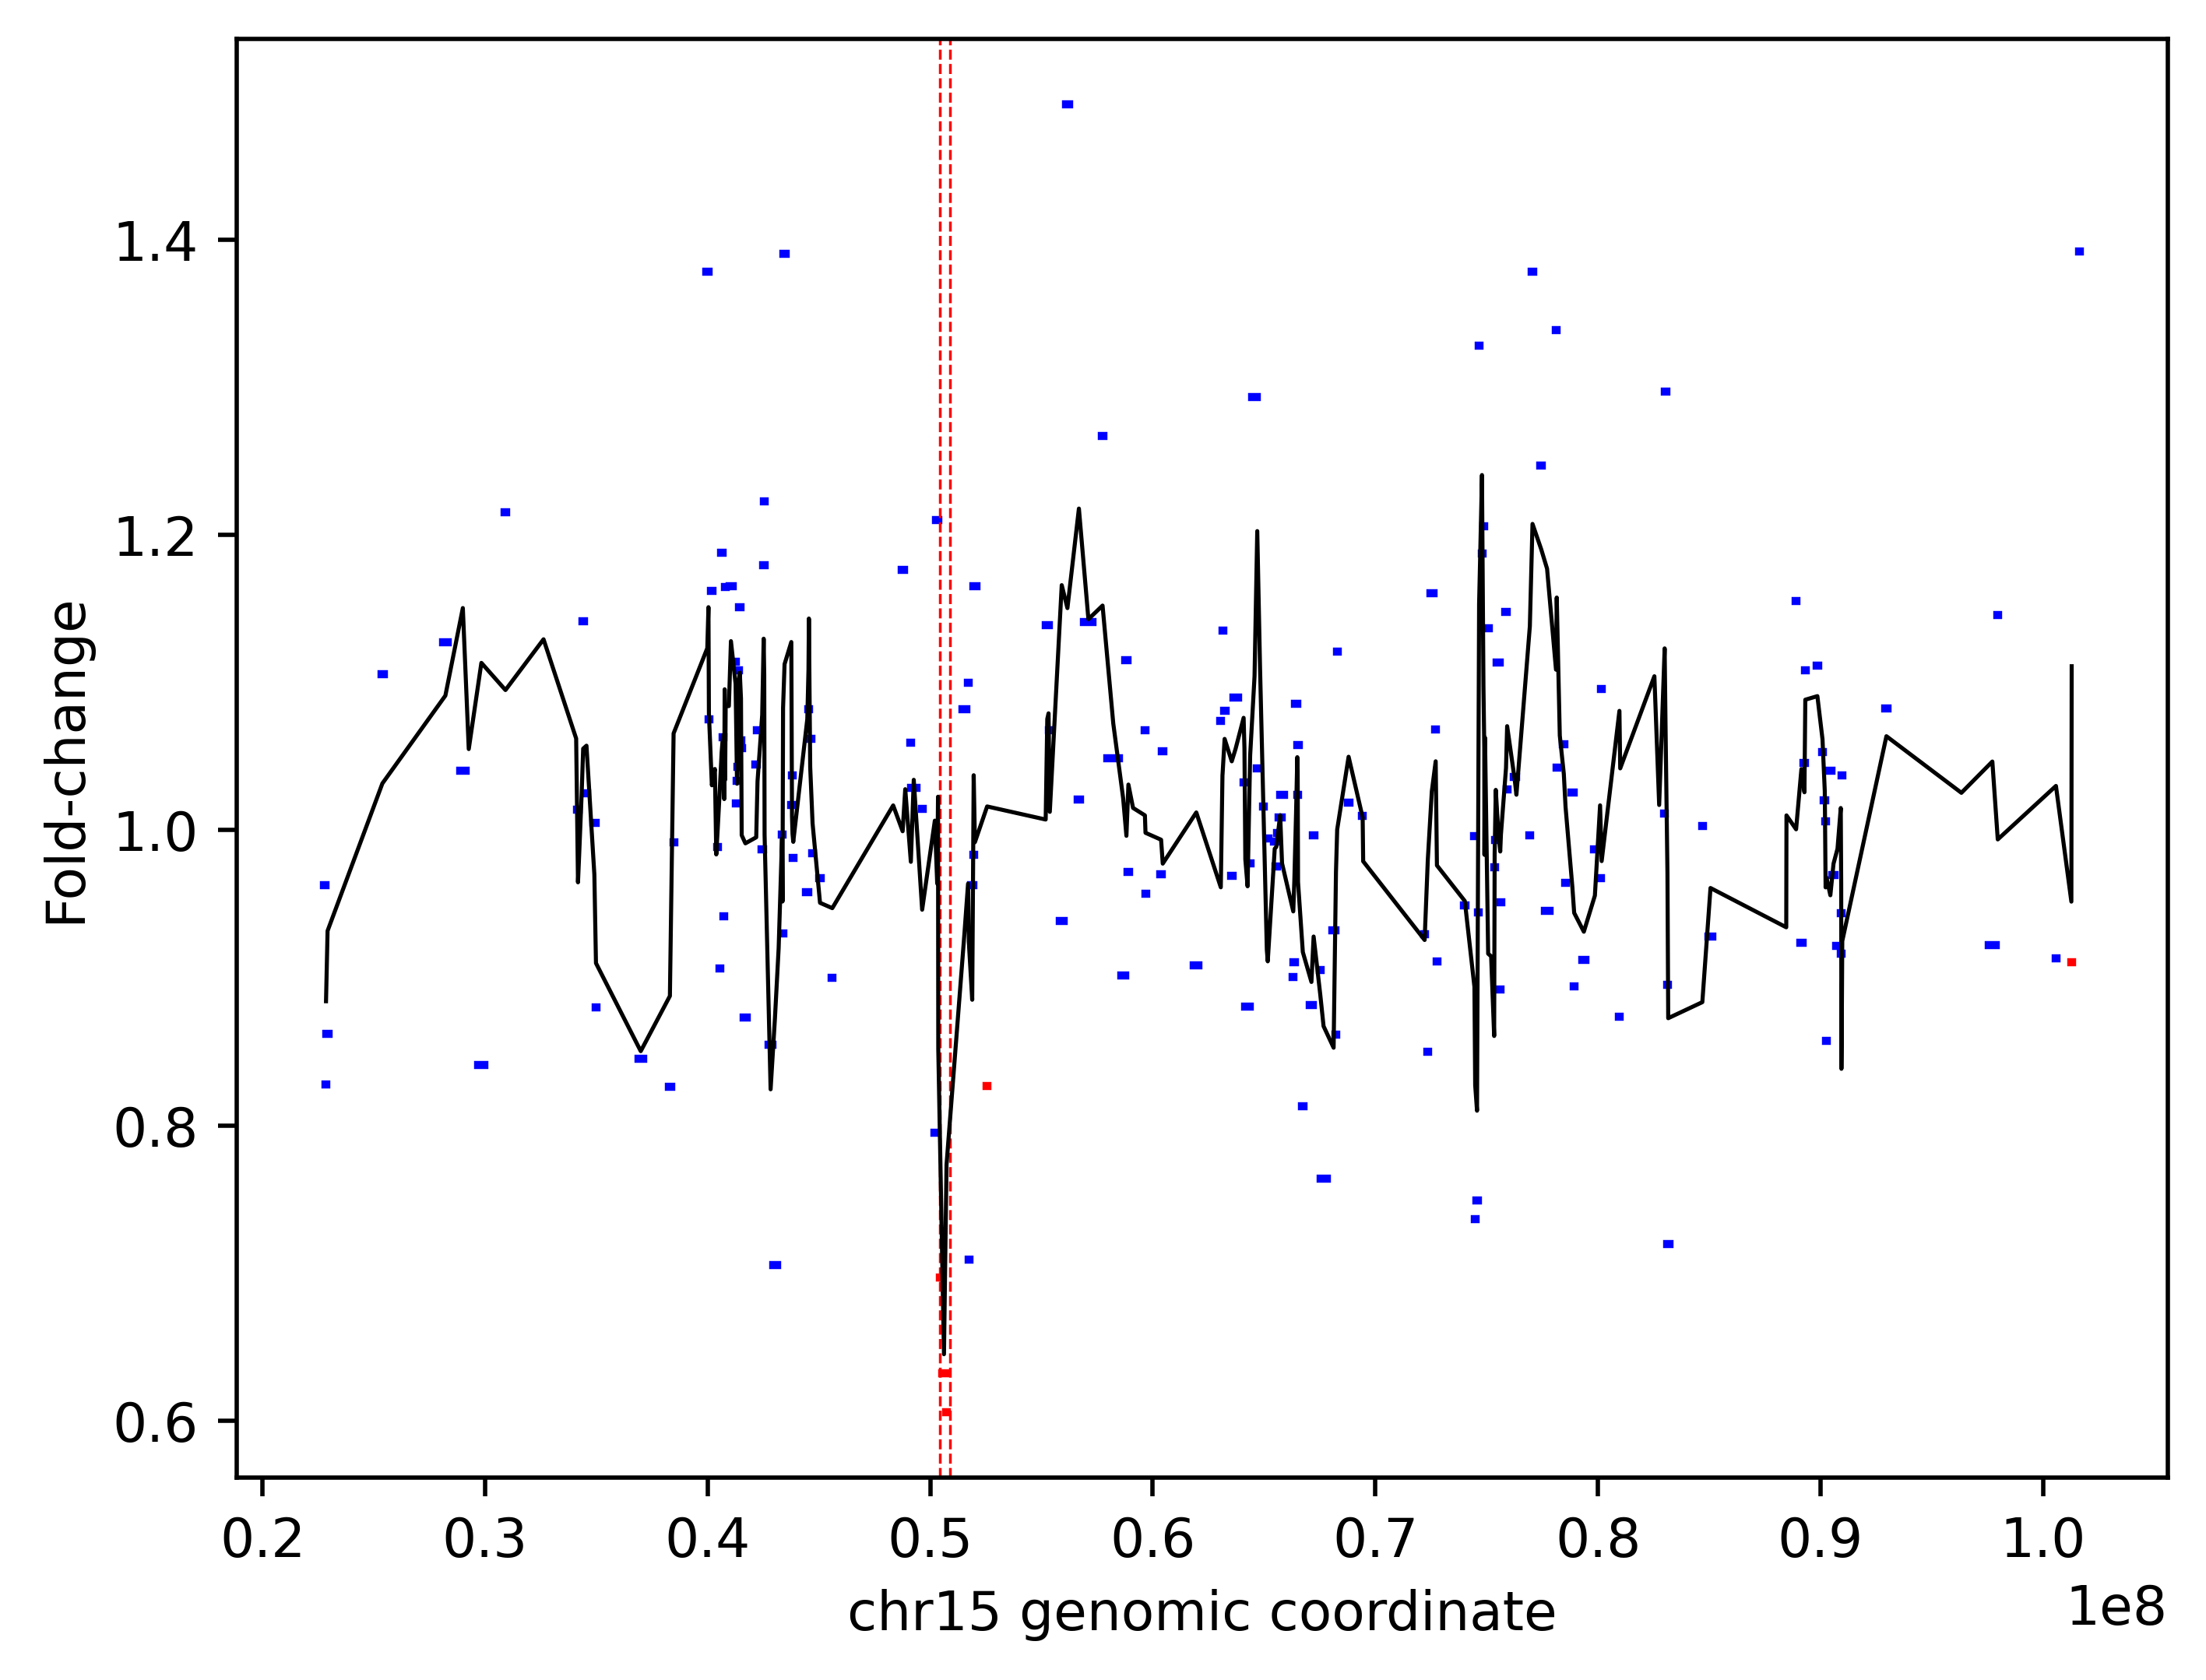

In [126]:
for i in info_df.index:
    plt.plot([info_df.loc[i,"start"],info_df.loc[i,"end"]],
              [info_df.loc[i,"Fold-change"],info_df.loc[i,"Fold-change"]], 
             color="blue" if float(info_df.loc[i,"p-value"]) > 0.05 else "red")#, 
             #alpha=1-float(info_df.loc[i,"p-value"]))#, cmap="Reds")
plt.axvline(x=start, linestyle="--", linewidth=0.5, color="red")
plt.axvline(x=end, linestyle="--", linewidth=0.5, color="red")
plt.xlabel("chr15 genomic coordinate")
plt.ylabel("Fold-change")

plt.plot(info_df.iloc[1:-1,:]['center'], moving_avg, color="black", linewidth=0.75)
plt.savefig("chr15_total.pdf", dpi=500)
plt.show()

# Downsampling cell number

In [134]:
start = 50426416
end = 50873610

In [135]:
start_left = start#-10000000
end_right = end#+10000000

In [136]:
del_idx = []
for i in chr15.index:
    if chr15.loc[i,"start"] >= start_left and chr15.loc[i,"end"] <= end_right:
        del_idx.append(i)
        print(1)
    elif chr15.loc[i,"end"] >= start_left and chr15.loc[i,"end"] <= end_right:
        del_idx.append(i)
        print(2)
    elif chr15.loc[i,"start"] >= start_left and chr15.loc[i,"start"] <= end_right:
        del_idx.append(i)
        print(3)

2
1
1
1
1
1
1
1
1
1
1
1
3


In [137]:
del_genes = chr15.loc[del_idx, "gene_name"].values

In [138]:
gen = [i for i in del_genes if i in adata.var.index]

In [139]:
gen_df = chr15[chr15['gene_name'].isin(gen)]

In [140]:
gen_df.set_index("gene_name", inplace=True)

In [141]:
gen_df

,seqname,start,end,attribute
gene_name,,,,
USP8,chr15,50424380,50514421,ID=ENSG00000138592.14;gene_id=ENSG00000138592....
TRPM7,chr15,50552473,50686797,ID=ENSG00000092439.16;gene_id=ENSG00000092439....
SPPL2A,chr15,50702266,50765709,ID=ENSG00000138600.10;gene_id=ENSG00000138600....


In [142]:
info_df = pd.DataFrame(index=gen, columns=['Fold-change', 'p-value', 'start', 'end', '%_group', '%_rest'])

In [143]:
from scipy.stats import ranksums

In [144]:
group = adata_test.obs[adata_test.obs['chr15_del']=="Yes"].index
rest = adata_test.obs[adata_test.obs['chr15_del']=="No"].index
for i in info_df.index:
    info_df.loc[i,"Fold-change"] = np.mean(adata_test[group,i].X)/np.mean(adata_test[rest,i].X)
    info_df.loc[i,"start"] = gen_df.loc[i,"start"]
    info_df.loc[i,"end"] = gen_df.loc[i,"end"]
    info_df.loc[i,"p-value"] = ranksums(adata_test[group,i].X, adata_test[rest,i].X, alternative='less')[1]
    info_df.loc[i,"%_group"] = np.count_nonzero(adata_test[group,i].X)/len(group)
    info_df.loc[i,"%_rest"] = np.count_nonzero(adata_test[rest,i].X)/len(rest)

In [145]:
info_df

,Fold-change,p-value,start,end,%_group,%_rest
USP8,0.696859,0.013165095902601539,50424380,50514421,0.234409,0.304412
TRPM7,0.632311,0.00046257519692091394,50552473,50686797,0.215054,0.329412
SPPL2A,0.605961,0.005182266390815851,50702266,50765709,0.15914,0.245588


In [146]:
info_df = info_df[info_df["%_group"]>=0.1]
info_df = info_df[info_df["%_rest"]>=0.1]

In [147]:
info_df

,Fold-change,p-value,start,end,%_group,%_rest
USP8,0.696859,0.013165095902601539,50424380,50514421,0.234409,0.304412
TRPM7,0.632311,0.00046257519692091394,50552473,50686797,0.215054,0.329412
SPPL2A,0.605961,0.005182266390815851,50702266,50765709,0.15914,0.245588


In [148]:
import random
import seaborn as sns

/tmp/4931021.1.shendure-login.q/ipykernel_1395294/2794394415.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'p_value': float(p_value),
/tmp/4931021.1.shendure-login.q/ipykernel_1395294/2794394415.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'neg_log10_p': float(-np.log10(p_value))
/tmp/4931021.1.shendure-login.q/ipykernel_1395294/2794394415.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'p_value': float(p_value),
/tmp/4931021.1.shendure-login.q/

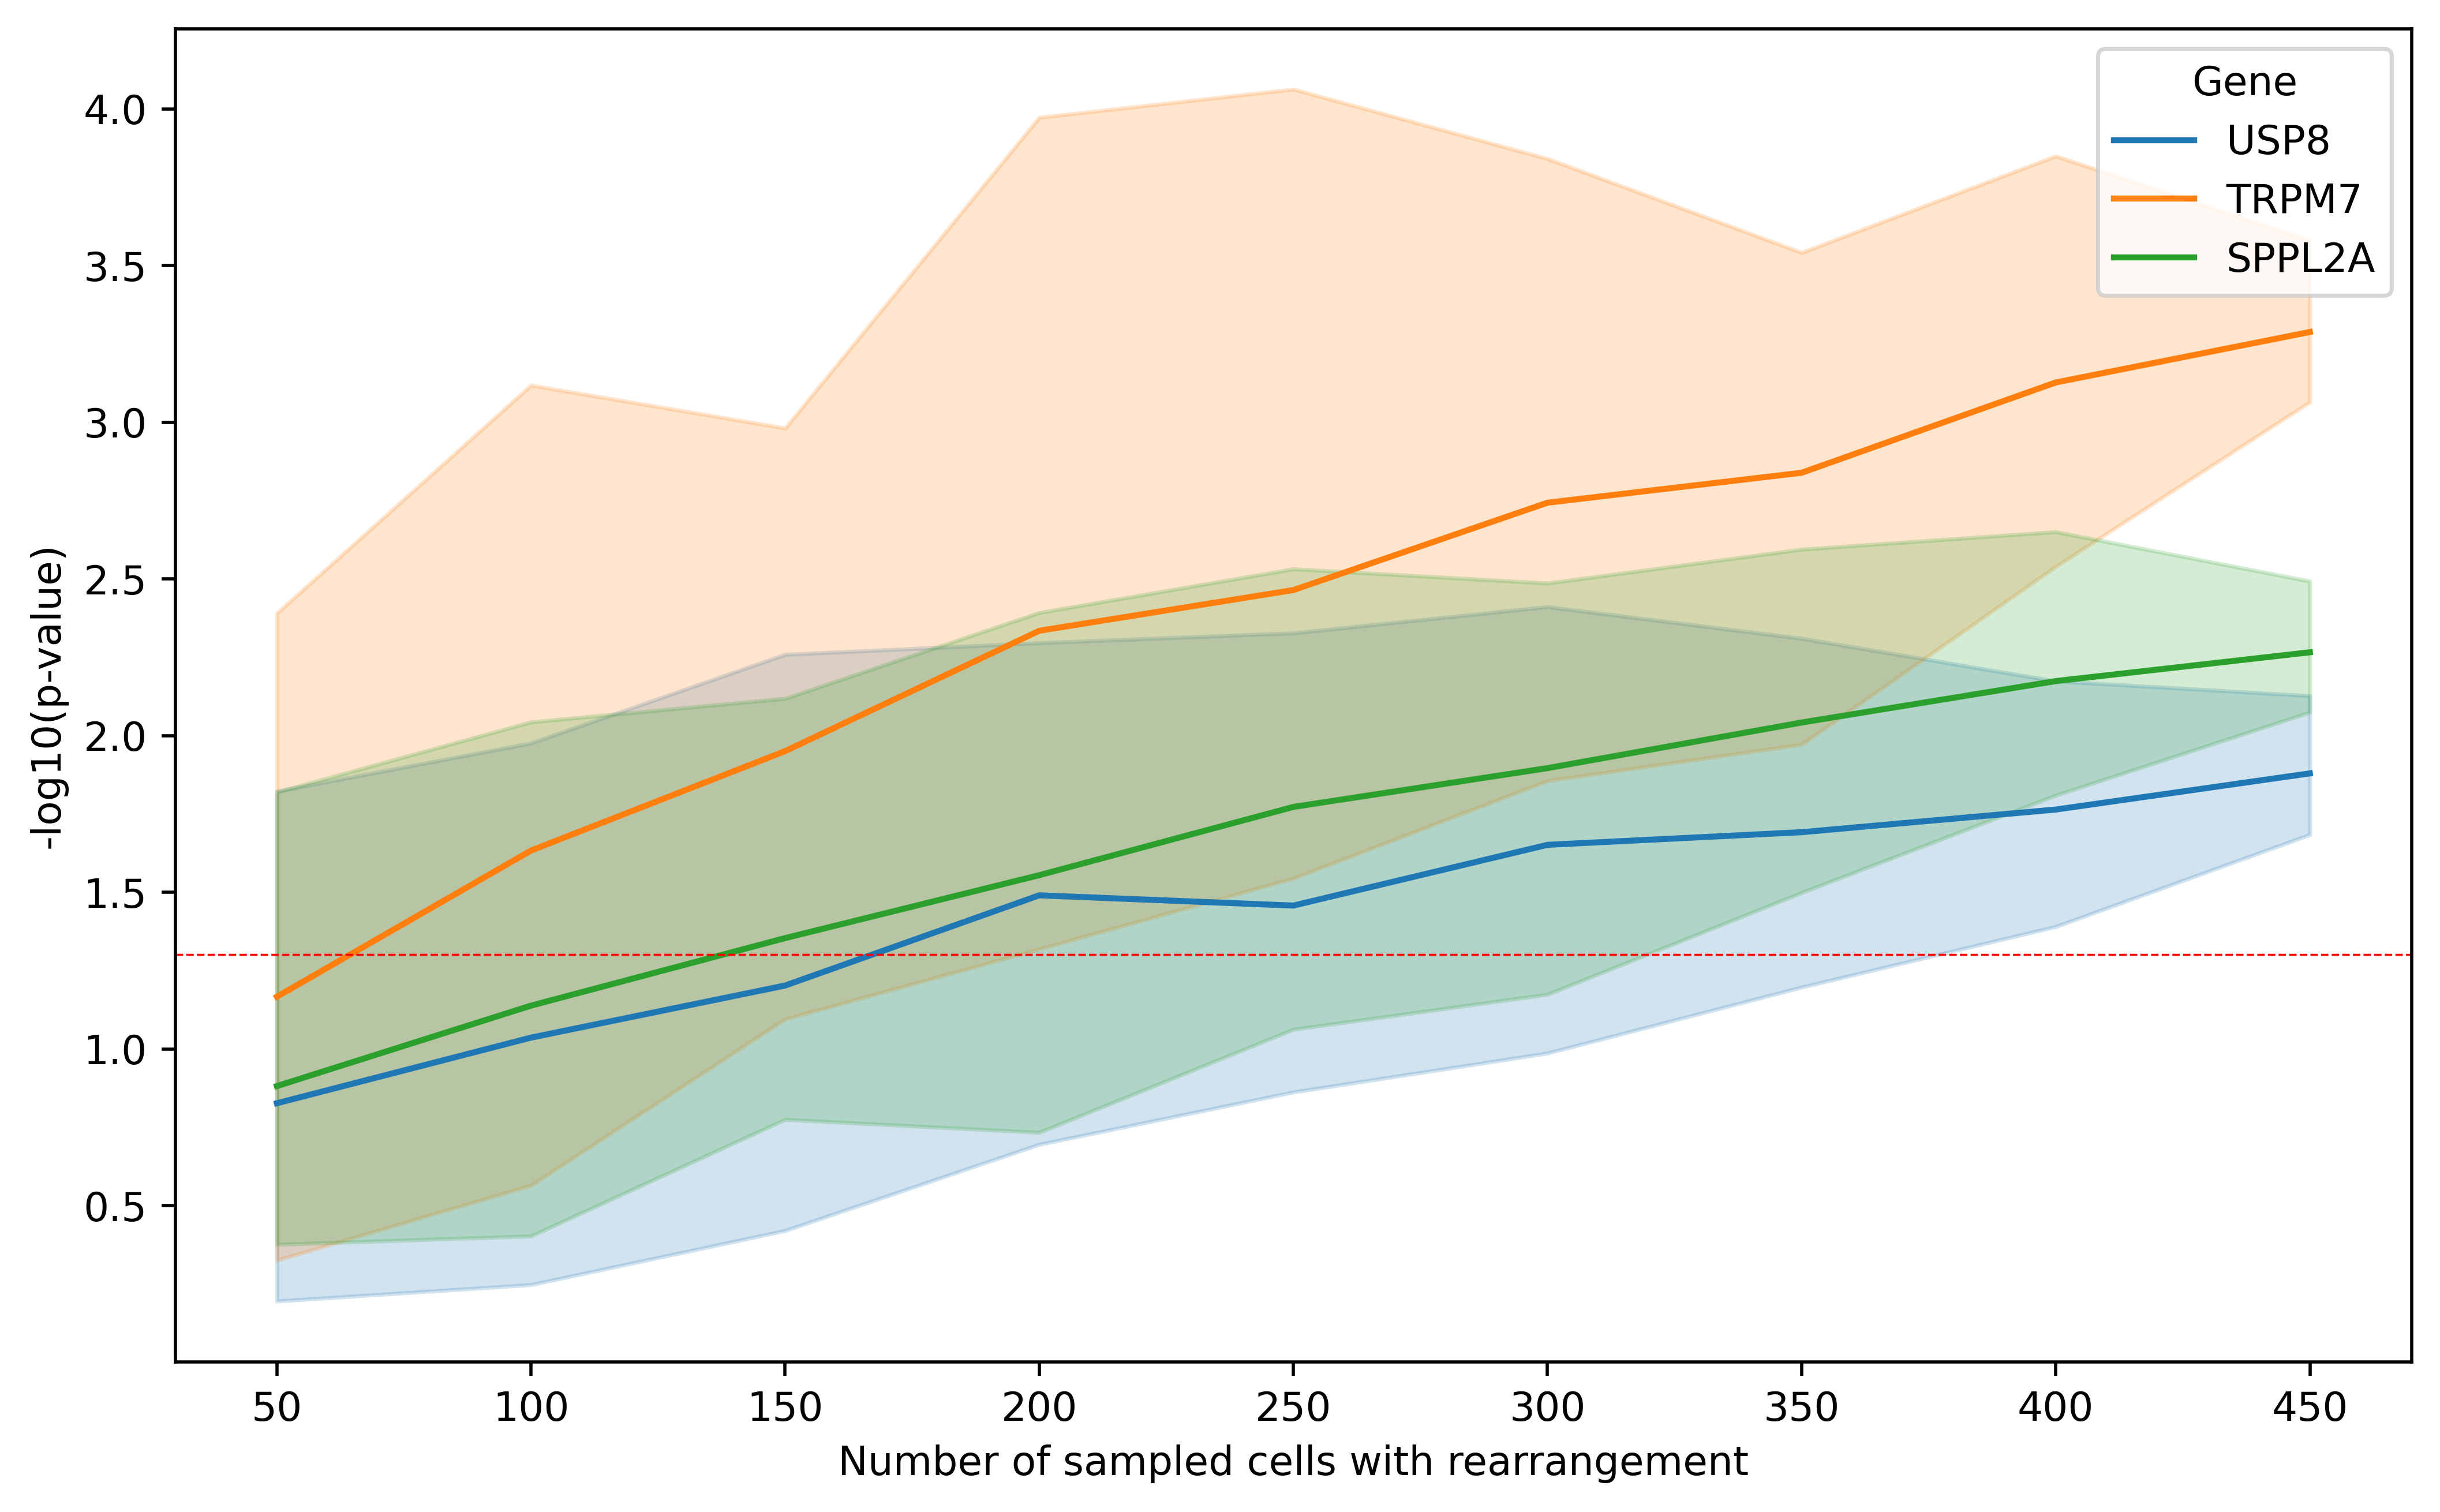

In [149]:
cell_counts = [50, 100, 150, 200, 250, 300, 350, 400, 450]
genes = ['USP8', 'TRPM7', 'SPPL2A']
n_iterations = 100

results = []

for cell_count in cell_counts:
    for iteration in range(n_iterations):
        rest = adata_test.obs[adata_test.obs['chr15_del'] == "No"].index
        group = random.sample(del_cells, cell_count)
        for gene in genes:
            p_value = ranksums(adata_test[group, gene].X, adata_test[rest, gene].X, alternative='less')[1]
            results.append({
                'cell_count': cell_count,
                'gene': gene,
                'p_value': float(p_value),
                'neg_log10_p': float(-np.log10(p_value))
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='cell_count', y='neg_log10_p', hue='gene', errorbar=('pi', 95))

plt.xlabel("Number of sampled cells with rearrangement")
plt.ylabel("-log10(p-value)")
plt.axhline(y=-np.log10(0.05), linestyle="--", linewidth=0.5, color="red")
#plt.title("P-value evolution with confidence intervals")
plt.legend(title="Gene")
plt.savefig("downsampling_pvalue.pdf", dpi=500)
plt.show()

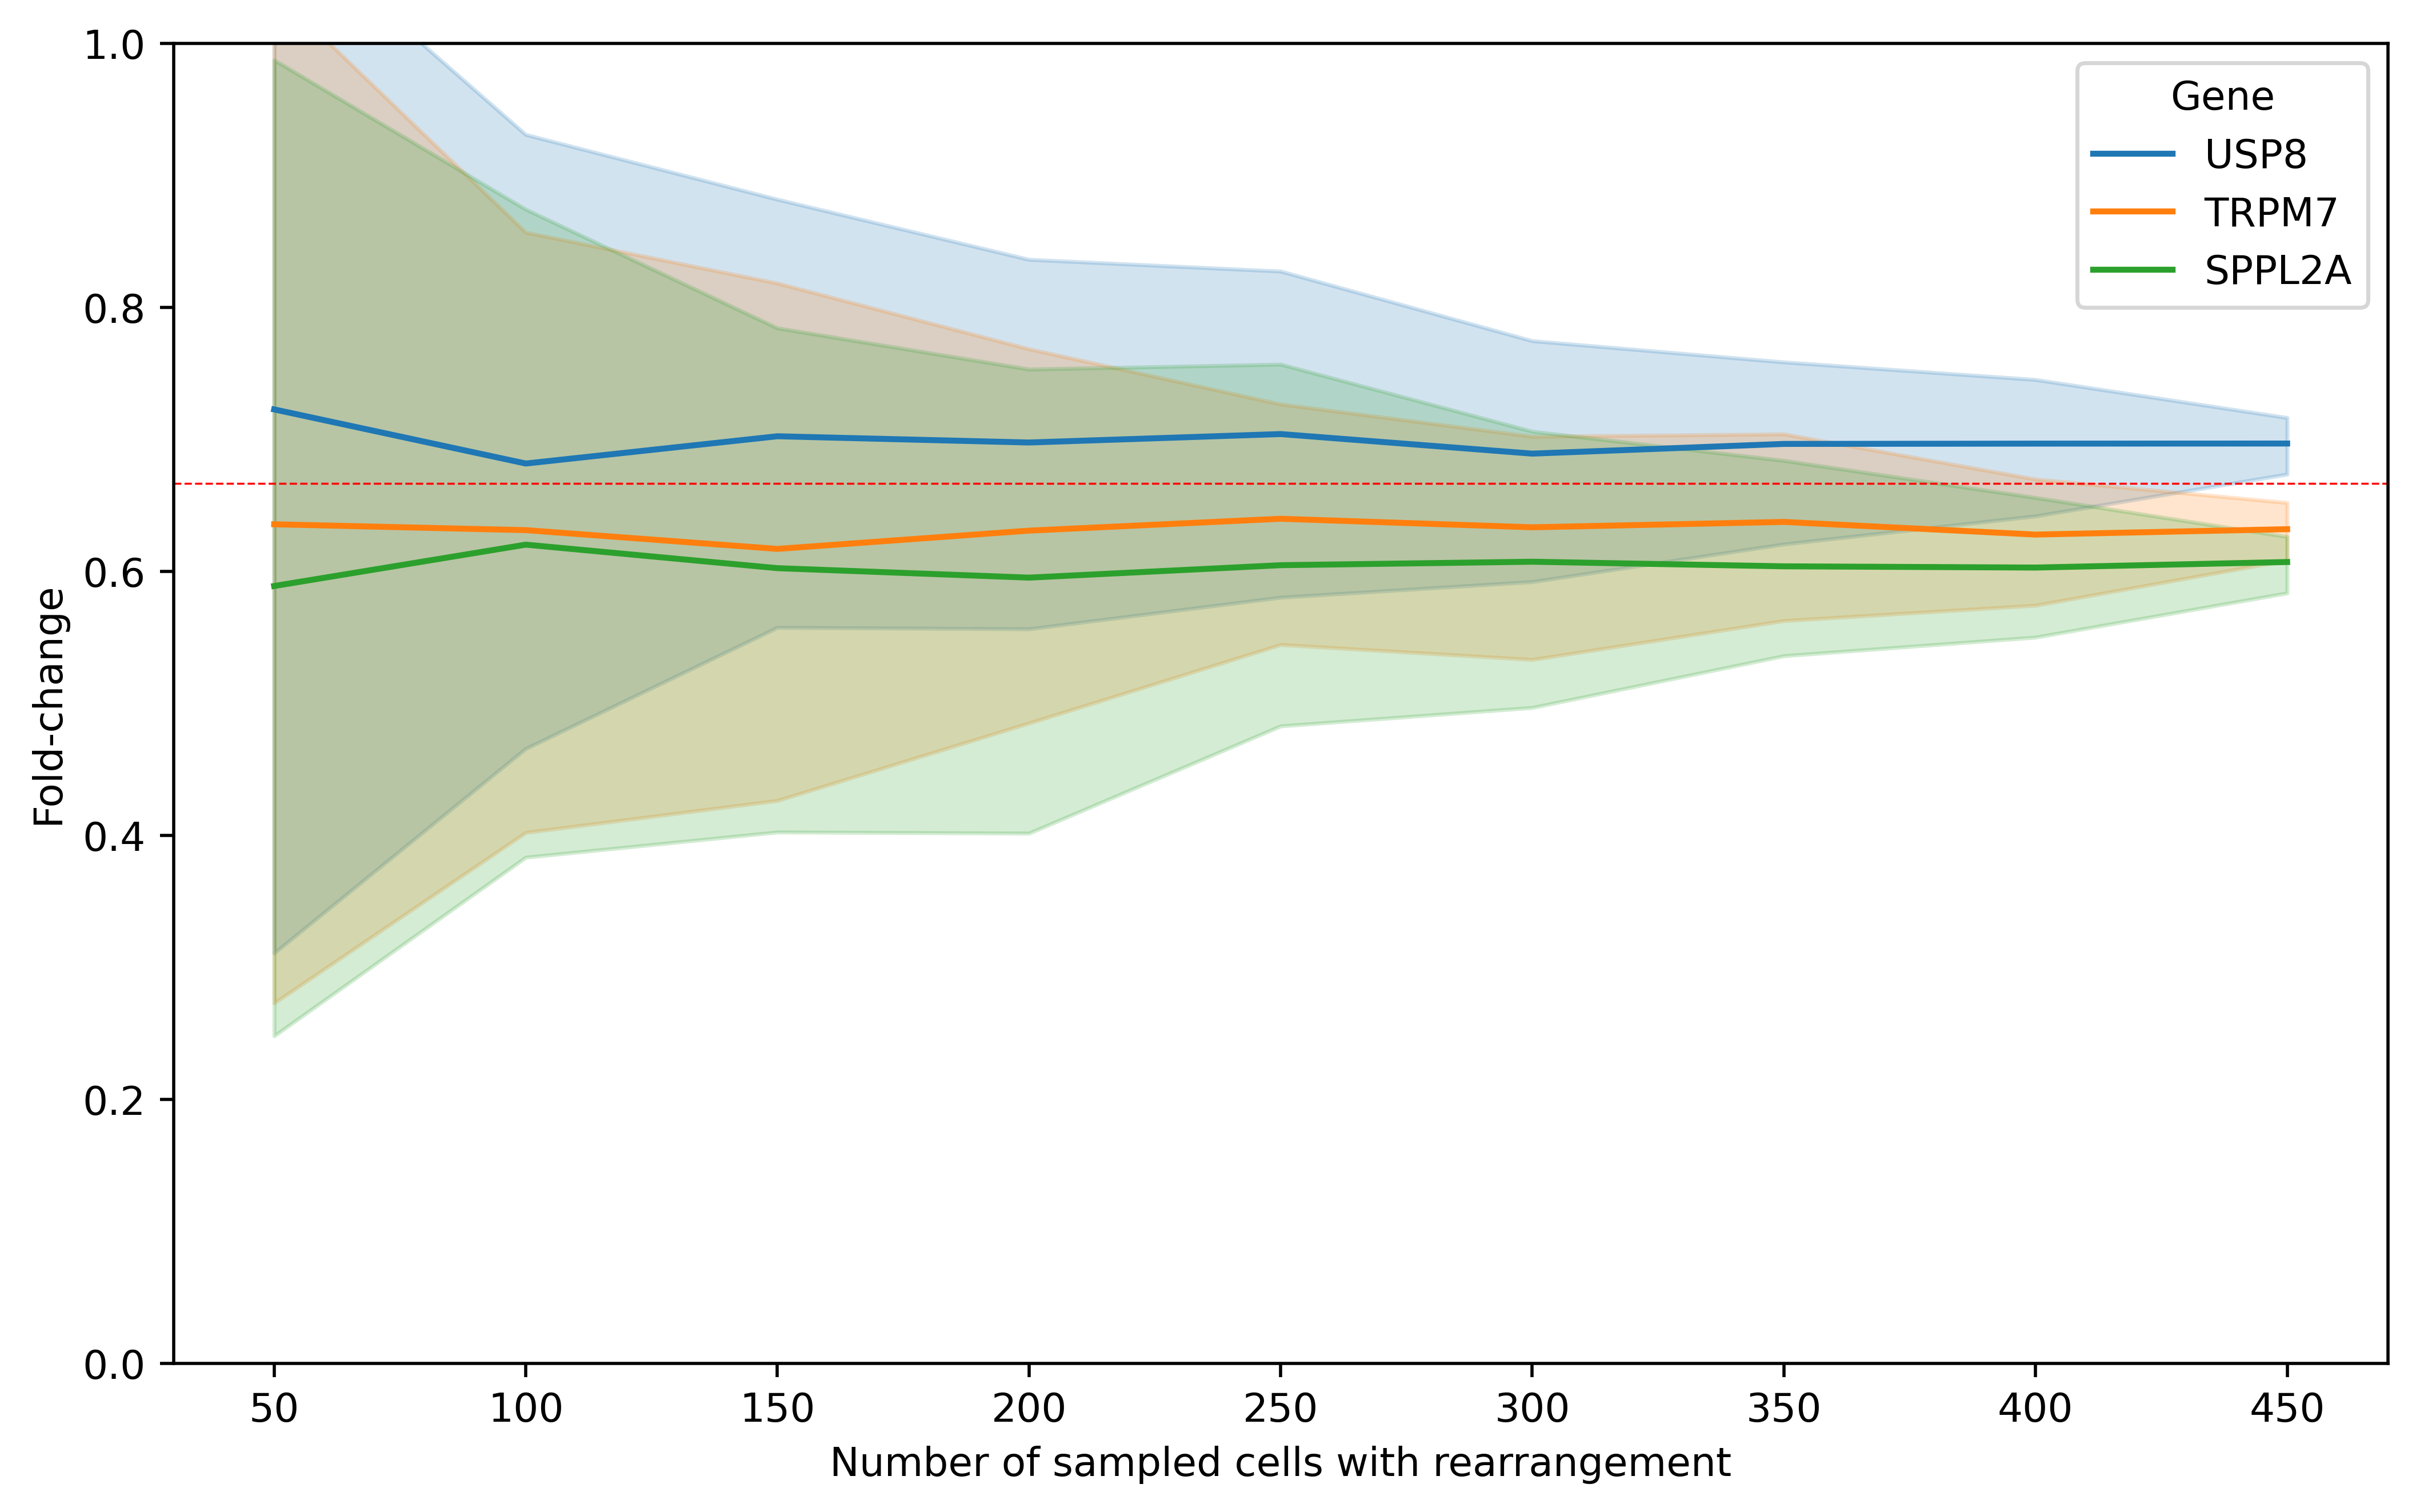

In [151]:
cell_counts = [50, 100, 150, 200, 250, 300, 350, 400, 450]
genes = ['USP8', 'TRPM7', 'SPPL2A']
n_iterations = 100

results = []

for cell_count in cell_counts:
    for iteration in range(n_iterations):
        rest = adata_test.obs[adata_test.obs['chr15_del'] == "No"].index
        group = random.sample(del_cells, cell_count)
        for gene in genes:
            p_value = np.mean(adata_test[group,gene].X)/np.mean(adata_test[rest,gene].X)
            results.append({
                'cell_count': cell_count,
                'gene': gene,
                'Fold-change': float(p_value),
                'neg_log10_p': float(-np.log10(p_value))
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='cell_count', y='Fold-change', hue='gene', errorbar=('pi',95))

plt.xlabel("Number of sampled cells with rearrangement")
plt.ylabel("Fold-change")
plt.ylim([0,1])
plt.axhline(y=(2.0/3.0), linestyle="--", linewidth=0.5, color="red")
#plt.title("Fold- evolution with confidence intervals")
plt.legend(title="Gene")
plt.savefig("downsampling_foldchange.pdf", dpi=500)
plt.show()